# Intro

The purpose of this notebook is to query the SAWGraph knowledge graph for paper industry facilities and their nearby sample results for PFAS testing.

For a specific industry of concern (e.g. papermills), how are the known releases linked to contamination in water and to fish tissue samples nearby or downstream?

# Setup

Here we set up SPARQLWrapper to work with our endpoint and create our query.

## Install & Import Statements

Install: The SPARQLWrapper libary provides tools for querying SPARQL endpoints. The sparql_dataframe library can be used with SPARQLWrapper to convert JSON results from a SPARQL query directly to a Pandas dataframe. The mapclassify library is required by GeoPandas for its .explore functionality.

Import: See the inline comments for a brief rational of each library.

In [ ]:
%%capture
!pip install mapclassify --upgrade --quiet
!pip install SPARQLWrapper --upgrade --quiet
!pip install sparql_dataframe --upgrade --quiet

In [ ]:
from branca.element import Figure                                  # For controlling the size of the final map
import folium                                                      # For map layer control
import geopandas as gpd                                            # For geospatial dataframes
import pandas as pd                                                # For dataframes
from shapely import wkt                                            # For working with WKT coordinates in a GeoDataFrame
from SPARQLWrapper import SPARQLWrapper, JSON, GET, POST, DIGEST   # For querying SPARQL endpoints
import sparql_dataframe                                            # For converting SPARQL query results to Pandas dataframes

## Server Connection Initialization

A SPARQLWrapper is created to access the SAWGraph repository for the SAWGraph project.

In [ ]:
%%capture

server = "https://gdb.acg.maine.edu:7200/" # @param ["https://gdb.acg.maine.edu:7200/","https://gdb.acg.maine.edu:7201/","http://tarski.ume/maine.edu:7200/"] {"allow-input":true}
#pd.options.display.width = 140

if server == "https://gdb.acg.maine.edu:7200/":
  endpointGET = 'https://gdb.acg.maine.edu:7200/repositories/Hydrology'
  hydrology = "Hydrology"
  admin = "S2L13_AdminRegions"
elif server == "http://tarski.ume/maine.edu:7200/":
  endpointGET = 'http://tarski.ume.maine.edu:7200/repositories/Hydrology'
  hydrology ="ME_Hydrology"
  admin ="ME_S2L13_and_AdminRegions"


sparqlGET = SPARQLWrapper(endpointGET)
sparqlGET.setHTTPAuth(DIGEST)
sparqlGET.setCredentials('sawgraph-endpoint', 'skailab')
sparqlGET.setMethod(GET)
sparqlGET.setReturnFormat(JSON)


## Queries

This query directly accesses data in  SAWGraph Knowledge Graph. It uses federation to access additional data in the FIO, S2L13_AdminRegions and Hydrology repositories.



The query is executed and returned as a dataframe.

In [ ]:
industry = "NAICS-IndustryGroup-3222" # @param ["NAICS-IndustryGroup-3222","NAICS-Subsector-322"]
# 3222: Only Converted Paper Manufacturing: 11 facilities, 2 with 2 industry codes
# 322: Paper Manufacturing (Mills and Paper Manufacturing Facilities): 46 facilities (though some duplicates)


In [ ]:
%%time
#Get paper product facilities
query1 = f"""
PREFIX naics: <http://sawgraph.spatialai.org/v1/fio/naics#>
PREFIX fio: <http://sawgraph.spatialai.org/v1/fio#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX kwg-ont: <http://stko-kwg.geog.ucsb.edu/lod/ontology/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
select DISTINCT ?facility ?faclabel (concat('[',group_concat(DISTINCT ?industry;separator='; '),']') as ?industries) (group_concat(DISTINCT ?industryLabel;separator='; ') as ?industryLabels) ?fac_wkt ?s2
where  {{
    SERVICE <repository:FIO> {{
    	?facility a fio:Facility .
        ?facility rdfs:label ?faclabel.
        ?facility geo:hasGeometry/geo:asWKT ?fac_wkt .
    	?facility fio:ofIndustry ?industry.
        #VALUES ?industry {{naics:NAICS-Industry-Code-32212}} #papermill
        ?industry rdfs:subClassOf naics:{industry}. #Only Converted Paper Manufacturing: 10 facilities
    	?industry rdfs:label ?industryLabel.
        ?facility kwg-ont:sfWithin ?s2.
    }}
     SERVICE <repository:{admin}>
    {{
        ?s2 a kwg-ont:S2Cell_Level13.
    }}
}} GROUP BY ?facility ?faclabel ?fac_wkt ?s2
"""
#Get s2 cells of facilities
query2 = f"""
PREFIX naics: <http://sawgraph.spatialai.org/v1/fio/naics#>
PREFIX fio: <http://sawgraph.spatialai.org/v1/fio#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX kwg-ont: <http://stko-kwg.geog.ucsb.edu/lod/ontology/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
select ?s2 ?s2WKT where  {{
    SERVICE <repository:FIO> {{
    	?facility a fio:Facility .
    	?facility fio:ofIndustry ?industry.
      ?industry rdfs:subClassOf naics:{industry}.
        ?facility kwg-ont:sfWithin ?s2.
    }}
     SERVICE <repository:{admin}>
    {{
        ?s2 a kwg-ont:S2Cell_Level13.
        ?s2 geo:hasGeometry/geo:asWKT ?s2WKT .

    }}
}}

"""
#Get waterbodies/flowlines from s2 cells
query3=f"""
PREFIX naics: <http://sawgraph.spatialai.org/v1/fio/naics#>
PREFIX fio: <http://sawgraph.spatialai.org/v1/fio#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX kwg-ont: <http://stko-kwg.geog.ucsb.edu/lod/ontology/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX hyf: <https://www.opengis.net/def/schema/hy_features/hyf/>
PREFIX schema: <https://schema.org/>
select ?s2 ?reach ?name ?wb_wkt where  {{
    SERVICE <repository:FIO> {{
    	?facility a fio:Facility .
    	?facility fio:ofIndustry ?industry.
      ?industry rdfs:subClassOf naics:{industry}.
      ?facility kwg-ont:sfWithin ?s2.
    }}
     SERVICE <repository:{admin}>
    {{
        ?s2 a kwg-ont:S2Cell_Level13.

    }}
    SERVICE <repository:{hydrology}>
    {{
        ?s2 kwg-ont:sfCrosses ?reach.
        ?reach a hyf:HY_FlowPath.

        ?reach geo:hasGeometry/geo:asWKT ?wb_wkt .
        OPTIONAL{{?reach schema:name ?name}}
    }}
}}
"""
#get downstream waterbodies
query4 = f"""
PREFIX naics: <http://sawgraph.spatialai.org/v1/fio/naics#>
PREFIX fio: <http://sawgraph.spatialai.org/v1/fio#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX kwg-ont: <http://stko-kwg.geog.ucsb.edu/lod/ontology/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX hyf: <https://www.opengis.net/def/schema/hy_features/hyf/>
PREFIX saw_water: <http://sawgraph.spatialai.org/v1/saw_water#>
select ?downstream ?downstream_wkt ?fl_type where  {{
    SERVICE <repository:FIO> {{
    	?facility a fio:Facility .
    	?facility fio:ofIndustry ?industry.
      ?industry rdfs:subClassOf naics:{industry}.
      ?facility kwg-ont:sfWithin ?s2.
    }}
     SERVICE <repository:{admin}>
    {{
        ?s2 a kwg-ont:S2Cell_Level13.

    }}
    SERVICE <repository:{hydrology}>
    {{
        ?s2 kwg-ont:sfCrosses ?reach.
        ?reach a hyf:HY_FlowPath.
        ?reach hyf:downstreamWaterbody+ ?downstream.
        ?downstream saw_water:hasFTYPE ?fl_type .
        FILTER ( ?fl_type != "Coastline" )
        ?downstream geo:hasGeometry/geo:asWKT ?downstream_wkt .
    }}
}} GROUP BY ?downstream ?downstream_wkt ?fl_type
"""

#get s2 cells from downstream waterbodies
query5 = f"""
PREFIX naics: <http://sawgraph.spatialai.org/v1/fio/naics#>
PREFIX fio: <http://sawgraph.spatialai.org/v1/fio#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX kwg-ont: <http://stko-kwg.geog.ucsb.edu/lod/ontology/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX hyf: <https://www.opengis.net/def/schema/hy_features/hyf/>
PREFIX saw_water: <http://sawgraph.spatialai.org/v1/saw_water#>
select ?s2downstream ?downstream_s2_wkt where  {{
    SERVICE <repository:FIO> {{
    	?facility a fio:Facility .
    	?facility fio:ofIndustry ?industry.
      ?industry rdfs:subClassOf naics:{industry}.
      ?facility kwg-ont:sfWithin ?s2.
    }}
    SERVICE <repository:{hydrology}>
    {{
        ?s2 kwg-ont:sfCrosses ?reach.
        ?reach a hyf:HY_FlowPath.
        ?reach hyf:downstreamWaterbody+ ?downstream.
        ?downstream saw_water:hasFTYPE ?fl_type .
        FILTER ( ?fl_type != "Coastline" )
        ?downstream kwg-ont:sfCrosses ?s2downstream.
    }}
         SERVICE <repository:{admin}>
    {{
        ?s2 a kwg-ont:S2Cell_Level13.
        ?s2downstream a kwg-ont:S2Cell_Level13.
        ?s2downstream geo:hasGeometry/geo:asWKT ?downstream_s2_wkt .

    }}
}} GROUP BY ?s2downstream ?downstream_s2_wkt
"""

query6 = f"""
PREFIX naics: <http://sawgraph.spatialai.org/v1/fio/naics#>
PREFIX fio: <http://sawgraph.spatialai.org/v1/fio#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX kwg-ont: <http://stko-kwg.geog.ucsb.edu/lod/ontology/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX hyf: <https://www.opengis.net/def/schema/hy_features/hyf/>
PREFIX coso: <http://sawgraph.spatialai.org/v1/contaminoso#>
PREFIX me_egad: <http://sawgraph.spatialai.org/v1/me-egad#>
PREFIX me_egad_data: <http://sawgraph.spatialai.org/v1/me-egad-data#>
PREFIX sosa: <http://www.w3.org/ns/sosa/>
PREFIX qudt: <http://qudt.org/schema/qudt/>
PREFIX saw_water: <http://sawgraph.spatialai.org/v1/saw_water#>
PREFIX stad: <http://sawgraph.spatialai.org/v1/stad#>
select ?samplePoint ?sp_wkt (?ptl as ?pointType) ?materialSample ?observation  ?sampleType ?substance ?substanceL ?value ?unit
where  {{
  #get all distinct downstream s2 cells
    {{select ?s2downstream where  {{
    SERVICE <repository:FIO> {{
    	?facility a fio:Facility .
    	?facility fio:ofIndustry ?industry.
      ?industry rdfs:subClassOf naics:{industry}.
      ?facility kwg-ont:sfWithin ?s2.
    }}
    SERVICE <repository:Hydrology>
    {{
        ?s2 kwg-ont:sfCrosses ?reach.
        ?reach a hyf:HY_FlowPath.
        ?reach hyf:downstreamWaterbody+ ?downstream.
        ?downstream saw_water:hasFTYPE ?fl_type .
        FILTER ( ?fl_type != "Coastline" )
        ?downstream kwg-ont:sfCrosses ?s2downstream.
    }}
         SERVICE <repository:S2L13_AdminRegions>
    {{
        ?s2 a kwg-ont:S2Cell_Level13.
        ?s2downstream a kwg-ont:S2Cell_Level13.
    }}
                }} GROUP BY ?s2downstream }}
    #samples in s2 cells, results of samples
    SERVICE <repository:SAWGraph>
    {{
        ?s2downstream kwg-ont:sfContains ?samplePoint.
        ?samplePoint a coso:SamplePoint.
        ?samplePoint geo:hasGeometry/geo:asWKT ?sp_wkt .
        ?samplePoint me_egad:samplePointType ?pointType.
        VALUES ?pointType {{me_egad:featureType.PD me_egad:featureType.RI me_egad:featureType.LK}}
		    ?pointType rdfs:label ?ptl.
        ?samplePoint ^coso:fromSamplePoint ?materialSample.
        ?materialSample coso:ofSampleMaterialType ?st.
        ?st rdfs:label ?sampleType.
        ?observation coso:analyzedSample ?materialSample.
        ?observation coso:ofSubstance ?substance.
        ?substance rdfs:label ?substanceL.
        ?observation sosa:hasResult ?measure.
        ?measure qudt:quantityValue ?result.
        ?result qudt:numericValue ?value.
        ?result qudt:unit ?unit.
        FILTER NOT EXISTS{{ ?measure a stad:StatisticalAggregateData}}
    }}
}} GROUP BY ?samplePoint ?sp_wkt ?ptl ?observation ?materialSample ?st ?sampleType ?substance ?substanceL ?value ?unit
"""


CPU times: user 9 µs, sys: 2 µs, total: 11 µs
Wall time: 15.7 µs


### Run Queries

In [ ]:
%%time
facility_df = sparql_dataframe.get(endpointGET, query1)
print(facility_df.info())
facility_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   facility        10 non-null     object
 1   faclabel        10 non-null     object
 2   industries      10 non-null     object
 3   industryLabels  10 non-null     object
 4   fac_wkt         10 non-null     object
 5   s2              10 non-null     object
dtypes: object(6)
memory usage: 608.0+ bytes
None
CPU times: user 27.6 ms, sys: 4.75 ms, total: 32.4 ms
Wall time: 724 ms


,facility,faclabel,industries,industryLabels,fac_wkt,s2
0,http://sawgraph.spatialai.org/v1/us-frs-data#d...,R T S PACKAGING LLC,[http://sawgraph.spatialai.org/v1/fio/naics#NA...,Folding Paperboard Box Manufacturing ; Corruga...,POINT (-70.35584 43.57448),http://stko-kwg.geog.ucsb.edu/lod/resource/s2....
1,http://sawgraph.spatialai.org/v1/us-frs-data#d...,SOUTHERN CONTAINER CORP.,[http://sawgraph.spatialai.org/v1/fio/naics#NA...,Corrugated and Solid Fiber Box Manufacturing,POINT (-70.35708 43.67662),http://stko-kwg.geog.ucsb.edu/lod/resource/s2....
2,http://sawgraph.spatialai.org/v1/us-frs-data#d...,INTERNATIONAL PAPER CONTAINER FACILITY,[http://sawgraph.spatialai.org/v1/fio/naics#NA...,Corrugated and Solid Fiber Box Manufacturing,POINT (-70.26326 44.0383),http://stko-kwg.geog.ucsb.edu/lod/resource/s2....
3,http://sawgraph.spatialai.org/v1/us-frs-data#d...,INTERNATIONAL PAPER COMPANY-PASSADUMKEAG,[http://sawgraph.spatialai.org/v1/fio/naics#NA...,Corrugated and Solid Fiber Box Manufacturing,POINT (-68.59575 45.21394),http://stko-kwg.geog.ucsb.edu/lod/resource/s2....
4,http://sawgraph.spatialai.org/v1/us-frs-data#d...,VOLK PACKAGING CORP,[http://sawgraph.spatialai.org/v1/fio/naics#NA...,Corrugated and Solid Fiber Box Manufacturing,POINT (-70.49212 43.46834),http://stko-kwg.geog.ucsb.edu/lod/resource/s2....


In [ ]:
from google.colab import files
facility_df.to_csv('facilities.csv')
files.download('facilities.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%time
s2_df = sparql_dataframe.get(endpointGET, query2)
print(s2_df.info())
s2_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s2      11 non-null     object
 1   s2WKT   11 non-null     object
dtypes: object(2)
memory usage: 304.0+ bytes
None
CPU times: user 45.7 ms, sys: 1.93 ms, total: 47.7 ms
Wall time: 590 ms


,s2,s2WKT
0,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,POLYGON ((-70.34952590112334 43.58100887284728...
1,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,POLYGON ((-70.34410516194998 43.68329391651671...
2,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,POLYGON ((-70.24928458235391 44.04390181785499...
3,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,POLYGON ((-70.34952590112334 43.58100887284728...
4,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,POLYGON ((-68.59077547510634 45.21712535193461...


In [ ]:
%%time
wb_df = sparql_dataframe.get(endpointGET, query3)
print(wb_df.info())
wb_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   s2      21 non-null     object
 1   reach   21 non-null     object
 2   name    10 non-null     object
 3   wb_wkt  21 non-null     object
dtypes: object(4)
memory usage: 800.0+ bytes
None
CPU times: user 19.9 ms, sys: 4.04 ms, total: 23.9 ms
Wall time: 500 ms


,s2,reach,name,wb_wkt
0,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,https://geoconnex.us/nhdplusv2/comid/6721687,NaN,LINESTRING Z (-70.37647420120163 43.6008209989...
1,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,https://geoconnex.us/nhdplusv2/comid/6722451,NaN,LINESTRING Z (-70.35517706790137 43.5813603323...
2,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,https://geoconnex.us/nhdplusv2/comid/6721697,Mill Brook,LINESTRING Z (-70.33446880126684 43.5980483323...
3,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,https://geoconnex.us/nhdplusv2/comid/6722441,Mill Brook,LINESTRING Z (-70.35162306790687 43.5796447323...
4,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,https://geoconnex.us/nhdplusv2/comid/6721977,NaN,LINESTRING Z (-70.36011346789371 43.5921083323...


In [ ]:
%%time
downstream_df = sparql_dataframe.get(endpointGET, query4)
print(downstream_df.info())
downstream_df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   downstream      170 non-null    object
 1   downstream_wkt  170 non-null    object
 2   fl_type         170 non-null    object
dtypes: object(3)
memory usage: 4.1+ KB
None
CPU times: user 31.4 ms, sys: 6.83 ms, total: 38.2 ms
Wall time: 1.01 s


,downstream,downstream_wkt,fl_type
0,https://geoconnex.us/nhdplusv2/comid/6721687,LINESTRING Z (-70.37647420120163 43.6008209989...,StreamRiver
1,https://geoconnex.us/nhdplusv2/comid/6722451,LINESTRING Z (-70.35517706790137 43.5813603323...,ArtificialPath
2,https://geoconnex.us/nhdplusv2/comid/6721725,LINESTRING Z (-70.35124786790749 43.5734475990...,StreamRiver
3,https://geoconnex.us/nhdplusv2/comid/6721735,LINESTRING Z (-70.34879606791128 43.5697197990...,StreamRiver
4,https://geoconnex.us/nhdplusv2/comid/6724801,LINESTRING Z (-70.34804286791245 43.5658093990...,ArtificialPath
...,...,...,...
165,https://geoconnex.us/nhdplusv2/comid/6724931,LINESTRING Z (-70.17623300151246 43.7975705986...,ArtificialPath
166,https://geoconnex.us/nhdplusv2/comid/6724933,LINESTRING Z (-70.17486846818127 43.7969117986...,ArtificialPath
167,https://geoconnex.us/nhdplusv2/comid/6724935,LINESTRING Z (-70.16325820153259 43.7918441320...,ArtificialPath
168,https://geoconnex.us/nhdplusv2/comid/6724927,LINESTRING Z (-70.14250566823148 43.7950507986...,ArtificialPath


In [ ]:
%%time
s2downstream_df = sparql_dataframe.get(endpointGET, query5)
s2downstream_df.head()

CPU times: user 29.5 ms, sys: 0 ns, total: 29.5 ms
Wall time: 1.37 s


,s2downstream,downstream_s2_wkt
0,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,"POLYGON ((-70.3616331924049 43.60192160508116,..."
1,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,POLYGON ((-70.34963150111012 43.59978211678127...
2,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,"POLYGON ((-70.3736346357104 43.60405964165373,..."
3,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,"POLYGON ((-70.3376295633928 43.59764117676212,..."
4,http://stko-kwg.geog.ucsb.edu/lod/resource/s2....,POLYGON ((-70.34952590112334 43.58100887284728...


In [ ]:
%%time
samples_df = sparql_dataframe.get(endpointGET, query6)
samples_df.head()

CPU times: user 25.6 ms, sys: 7.06 ms, total: 32.6 ms
Wall time: 1.48 s


,samplePoint,sp_wkt,pointType,materialSample,observation,sampleType,substance,substanceL,value,unit
0,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.3239539 43.7041331),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SURFACE WATER,http://sawgraph.spatialai.org/v1/me-egad#param...,PERFLUOROOCTANE SULFONIC ACID,2.030,http://qudt.org/vocab/unitNanoGM-PER-L
1,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.3239539 43.7041331),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SURFACE WATER,http://sawgraph.spatialai.org/v1/me-egad#param...,PERFLUOROPENTANOIC ACID,1.070,http://qudt.org/vocab/unitNanoGM-PER-L
2,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.3239539 43.7041331),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SURFACE WATER,http://sawgraph.spatialai.org/v1/me-egad#param...,6:2 FLUOROTELOMER SULFONIC ACID,3.320,http://qudt.org/vocab/unitNanoGM-PER-L
3,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.3239539 43.7041331),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SURFACE WATER,http://sawgraph.spatialai.org/v1/me-egad#param...,PERFLUOROHEXANOIC ACID,0.973,http://qudt.org/vocab/unitNanoGM-PER-L
4,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.3239539 43.7041331),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SURFACE WATER,http://sawgraph.spatialai.org/v1/me-egad#param...,PERFLUOROOCTANOIC ACID,1.890,http://qudt.org/vocab/unitNanoGM-PER-L


In [ ]:
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   samplePoint     479 non-null    object 
 1   sp_wkt          479 non-null    object 
 2   pointType       479 non-null    object 
 3   materialSample  479 non-null    object 
 4   observation     479 non-null    object 
 5   sampleType      479 non-null    object 
 6   substance       479 non-null    object 
 7   substanceL      479 non-null    object 
 8   value           479 non-null    float64
 9   unit            479 non-null    object 
dtypes: float64(1), object(9)
memory usage: 37.5+ KB


To download the samples as a CSV file:


In [ ]:
from google.colab import files
samples_df.to_csv('samples.csv')
files.download('samples.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
facility_df['fac_wkt'] = facility_df['fac_wkt'].apply(wkt.loads)
s2_df['s2WKT'] = s2_df['s2WKT'].apply(wkt.loads)


In [ ]:
wb_df['wb_wkt'] = wb_df['wb_wkt'].apply(wkt.loads)
downstream_df['downstream_wkt'] = downstream_df['downstream_wkt'].apply(wkt.loads)
s2downstream_df['downstream_s2_wkt'] = s2downstream_df['downstream_s2_wkt'].apply(wkt.loads)
samples_df['sp_wkt'] = samples_df['sp_wkt'].apply(wkt.loads)

Create Geodataframes

In [ ]:
facility_gdf = gpd.GeoDataFrame(facility_df, geometry='fac_wkt')
facility_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)

s2_gdf = gpd.GeoDataFrame(s2_df, geometry='s2WKT')
s2_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)

wb_gdf = gpd.GeoDataFrame(wb_df, geometry='wb_wkt')
wb_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)

downstream_gdf = gpd.GeoDataFrame(downstream_df, geometry='downstream_wkt')
downstream_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)

s2downstream_gdf = gpd.GeoDataFrame(s2downstream_df, geometry='downstream_s2_wkt')
s2downstream_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)

samples_gdf = gpd.GeoDataFrame(samples_df, geometry='sp_wkt')
samples_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)

,samplePoint,sp_wkt,pointType,materialSample,observation,sampleType,substance,substanceL,value,unit
0,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.32395 43.70413),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SURFACE WATER,http://sawgraph.spatialai.org/v1/me-egad#param...,PERFLUOROOCTANE SULFONIC ACID,2.0300,http://qudt.org/vocab/unitNanoGM-PER-L
1,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.32395 43.70413),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SURFACE WATER,http://sawgraph.spatialai.org/v1/me-egad#param...,PERFLUOROPENTANOIC ACID,1.0700,http://qudt.org/vocab/unitNanoGM-PER-L
2,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.32395 43.70413),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SURFACE WATER,http://sawgraph.spatialai.org/v1/me-egad#param...,6:2 FLUOROTELOMER SULFONIC ACID,3.3200,http://qudt.org/vocab/unitNanoGM-PER-L
3,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.32395 43.70413),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SURFACE WATER,http://sawgraph.spatialai.org/v1/me-egad#param...,PERFLUOROHEXANOIC ACID,0.9730,http://qudt.org/vocab/unitNanoGM-PER-L
4,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.32395 43.70413),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SURFACE WATER,http://sawgraph.spatialai.org/v1/me-egad#param...,PERFLUOROOCTANOIC ACID,1.8900,http://qudt.org/vocab/unitNanoGM-PER-L
...,...,...,...,...,...,...,...,...,...,...
474,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.76320 44.12443),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SKINLESS FILLET,http://sawgraph.spatialai.org/v1/me-egad#param...,N-ETHYL PERFLUOROOCTANE SULFONAMIDOACETIC ACID,0.1738,http://sawgraph.spatialai.org/v1/me-egad#unit....
475,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.76320 44.12443),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SKINLESS FILLET,http://sawgraph.spatialai.org/v1/me-egad#param...,PERFLUOROOCTANE SULFONATE,6.7070,http://sawgraph.spatialai.org/v1/me-egad#unit....
476,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.76320 44.12443),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SKINLESS FILLET,http://sawgraph.spatialai.org/v1/me-egad#param...,PERFLUORODECANOATE,0.8644,http://sawgraph.spatialai.org/v1/me-egad#unit....
477,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.76320 44.12443),RIVER,http://sawgraph.spatialai.org/v1/me-egad-data#...,http://sawgraph.spatialai.org/v1/me-egad-data#...,SKINLESS FILLET,http://sawgraph.spatialai.org/v1/me-egad#param...,PERFLUOROOCTANE SULFONAMIDE,0.7263,http://sawgraph.spatialai.org/v1/me-egad#unit....


###Visualize tabular results

<ipython-input-20-adb2b388f0ea>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(samples_gdf, x='value', y='sampleType', inner='stick', palette='Dark2')


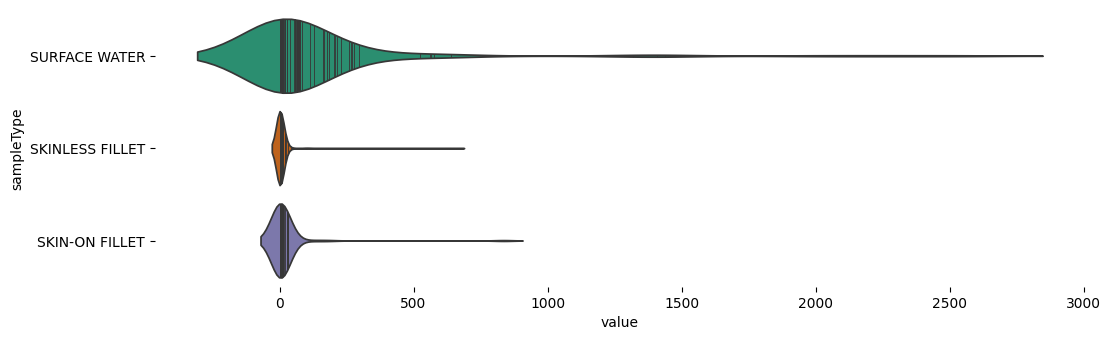

In [ ]:
# @title sampleType vs value

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(samples_gdf['sampleType'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(samples_gdf, x='value', y='sampleType', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

If needed, we can filter the results by specific PFAS chemicals we're interested in.

In [ ]:
samples_PFOS_gdf = samples_gdf[
    samples_gdf['substanceL'].isin(['PERFLUOROOCTANE SULFONIC ACID', 'PERFLUOROOCTANE SULFONATE'])
]

samples_PFOS_gdf.head()
samples_PFOS_gdf.info()

from google.colab import files
samples_PFOS_gdf.to_csv('samples-PFOS.csv')
files.download('samples-PFOS.csv')

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 74 entries, 0 to 710
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   samplePoint     74 non-null     object  
 1   sp_wkt          74 non-null     geometry
 2   pointType       74 non-null     object  
 3   materialSample  74 non-null     object  
 4   observation     74 non-null     object  
 5   sampleType      74 non-null     object  
 6   substance       74 non-null     object  
 7   substanceL      74 non-null     object  
 8   value           74 non-null     float64 
 9   unit            74 non-null     object  
dtypes: float64(1), geometry(1), object(8)
memory usage: 6.4+ KB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Aggregate all samples by location (that is, sample points) and find the lowest and highest concentration values for each point (assuming that all concentrations are in the same unit).
For the highest concentration, we also retrieve the specific substance for which that concentration was measured.

In [ ]:
agg_samples_df = samples_gdf[['samplePoint', 'sp_wkt', 'sampleType', 'value', 'substanceL']].sort_values(by=['value'], ascending=False).groupby(['samplePoint', 'sp_wkt', 'sampleType']).agg(max=('value', 'max'), max_chem=('substanceL', 'first'), min=('value', 'min')).reset_index()

In [ ]:
agg_samples_df

,samplePoint,sp_wkt,sampleType,max,max_chem,min
0,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.62967 44.54454),SKINLESS FILLET,20.420,PERFLUOROOCTANE SULFONATE,0.4083
1,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.62967 44.54454),SURFACE WATER,1.720,PERFLUOROBUTANOIC ACID,0.2840
2,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.67614 44.50110),SKIN-ON FILLET,28.300,PERFLUOROOCTANE SULFONATE,3.7000
3,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.46423 43.49886),SKIN-ON FILLET,3.610,PERFLUOROOCTANE SULFONATE,0.4310
4,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.70560 44.42156),SKIN-ON FILLET,32.200,PERFLUOROOCTANE SULFONATE,0.5900
5,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.67614 44.50110),SKIN-ON FILLET,33.500,PERFLUOROOCTANE SULFONATE,0.3480
6,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.61371 44.58671),SKIN-ON FILLET,836.000,PERFLUOROOCTANE SULFONIC ACID,0.0520
7,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.61371 44.58671),SKINLESS FILLET,660.000,PERFLUOROOCTANE SULFONIC ACID,0.0280
8,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.61371 44.58671),SURFACE WATER,2540.000,PERFLUOROOCTANE SULFONIC ACID,0.3170
9,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.77657 44.30039),SKINLESS FILLET,12.500,PERFLUOROOCTANE SULFONATE,0.1475


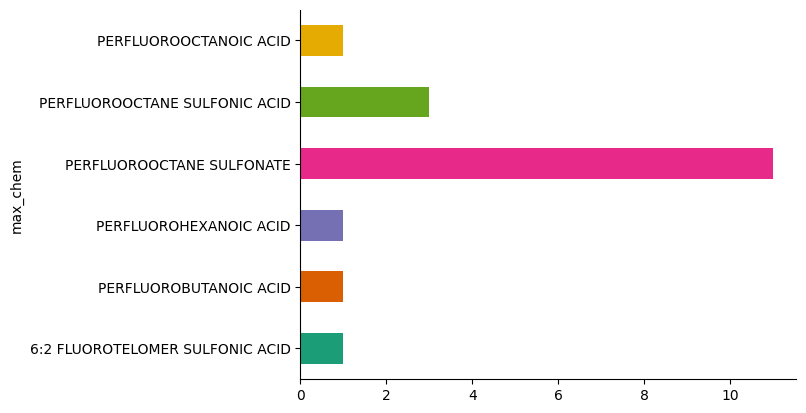

In [ ]:
# @title max_chem

from matplotlib import pyplot as plt
import seaborn as sns
agg_samples_df.groupby('max_chem').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Similarly, we can find the highest and lowest results for just the filtered (e.g. PFOS samples).

In [ ]:
agg_samples_PFOS_df = samples_PFOS_gdf[['samplePoint', 'sp_wkt', 'sampleType', 'value']].groupby(['samplePoint', 'sp_wkt', 'sampleType']).agg(max=('value', 'max'), min=('value', 'min'), mean=('value', 'mean'), count=('value', 'count')).reset_index()
agg_samples_PFOS_df

,samplePoint,sp_wkt,sampleType,max,min,mean,count
0,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.62967 44.54454),SKINLESS FILLET,20.4200,11.7600,16.090000,2
1,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.62967 44.54454),SURFACE WATER,1.5700,1.5700,1.570000,1
2,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.67614 44.50110),SKIN-ON FILLET,28.3000,28.3000,28.300000,1
3,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.09861 44.00310),SKIN-ON FILLET,15.8000,15.8000,15.800000,1
4,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-70.46423 43.49886),SKIN-ON FILLET,3.6100,3.6100,3.610000,1
5,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.70560 44.42156),SKIN-ON FILLET,32.2000,32.2000,32.200000,1
6,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.67614 44.50110),SKIN-ON FILLET,33.5000,33.5000,33.500000,1
7,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.61371 44.58671),SKIN-ON FILLET,836.0000,125.0000,380.666667,3
8,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.61371 44.58671),SKINLESS FILLET,660.0000,94.6000,220.820000,5
9,http://sawgraph.spatialai.org/v1/me-egad-data#...,POINT (-69.61371 44.58671),SURFACE WATER,2540.0000,1990.0000,2263.333333,3


In [ ]:
from google.colab import files
agg_samples_df.to_csv('samples-aggregated.csv')
files.download('samples-aggregated.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
agg_samples_gdf = gpd.GeoDataFrame(agg_samples_df, geometry='sp_wkt')
agg_samples_gdf.set_crs(epsg=4326, inplace=True, allow_override=True)
agg_samples_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   samplePoint  34 non-null     object  
 1   sp_wkt       34 non-null     geometry
 2   sampleType   34 non-null     object  
 3   max          34 non-null     float64 
 4   max_chem     34 non-null     object  
 5   min          34 non-null     float64 
dtypes: float64(2), geometry(1), object(3)
memory usage: 1.7+ KB


# Visualizing on a map

## Create map with multiple layers

Each GeoDataFrame is a layer in the final map.

In [ ]:
from folium.plugins import MarkerCluster
from folium import CircleMarker

In [ ]:
#%%capture
wb_color = 'DarkBlue'
downstream_color= 'DodgerBlue'
fac_color = 'red'
s2_color = 'light gray'
s2n_color = 'LightCyan'
boundweight = 3
industry=folium.map.Icon(icon='fa-regular fa-industry', prefix='fa')

map = facility_gdf.explore(color=fac_color,
                     marker_kwds=dict(radius=5, icon=industry),
                     style_kwds=dict(weight=boundweight),
                     tooltip=True,
                     name='Facilities',
                     show=True)

s2_gdf.explore(m=map,
               color=s2_color,
               style_kwds=dict(weight=boundweight),
               tooltip=False,
               name='S2 Cells',
               show=False)
downstream_gdf.explore(m=map,
               color=downstream_color,
               style_kwds=dict(weight=boundweight),
               tooltip=True,
               name='Downstream Reaches',
               show=True)
wb_gdf.explore(m=map,
               color=wb_color,
               style_kwds=dict(weight=boundweight),
               tooltip=True,
               name='Reaches',
               show=False)

s2downstream_gdf.explore(m=map,
               color=s2n_color,
               style_kwds=dict(weight=boundweight),
               tooltip=False,
               name='Downstream S2 Cells',
               show=False)

#marker_cluster = MarkerCluster(name="Water Samples"e).add_to(map)

agg_samples_gdf[agg_samples_gdf.sampleType == 'SURFACE WATER'].explore(m=map,
               color='blue',
               style_kwds=dict(style_function=lambda x: {"radius": (x['properties']["max"]) if (x['properties']["max"]) < 20 else 21 }),
              #marker_kwds=dict(radius=agg_samples_gdf['max']),
               popup=True,
               name='Water Samples',
               show=True)
agg_samples_gdf[agg_samples_gdf.sampleType == 'SKINLESS FILLET' ].explore(m=map,
               color='salmon',
               style_kwds=dict(style_function=lambda x: {"radius": (x['properties']["max"]) if (x['properties']["max"]) < 20 else 21 }),
               popup=True,
               name='Skinless Fish Samples',
               show=True)
agg_samples_gdf[agg_samples_gdf.sampleType == 'SKIN-ON FILLET' ].explore(m=map,
               color='pink',
               style_kwds=dict(style_function=lambda x: {"radius": (x['properties']["max"]) if (x['properties']["max"]) < 20 else 21 }),
               popup=True,
               name='Skin-On Fish Samples',
               show=True)


# folium.TileLayer("stamenterrain", show=False).add_to(map)
# folium.TileLayer("MapQuest Open Aerial", show=False).add_to(map)
folium.LayerControl(collapsed=False).add_to(map)

This variation adds all sample points and clusters the markers together for readability

In [ ]:
map2 = facility_gdf.explore(color=fac_color,
                     style_kwds=dict(weight=boundweight),
                     tooltip=True,
                     name='Facilities',
                     show=True)
downstream_gdf.explore(m=map2,
               color=downstream_color,
               style_kwds=dict(weight=boundweight),
               tooltip=True,
               name='Downstream Reaches',
               show=True)

marker_cluster = MarkerCluster(name="Samples").add_to(map2)

samples_gdf[samples_gdf.sampleType == 'SURFACE WATER'].explore(m=marker_cluster,
               color='blue',
               style_kwds=dict(weight=boundweight, style_function=lambda x: {"radius": (x['properties']["value"]) if (x['properties']["value"]) < 20 else 21 }),
               categories=samples_gdf.substanceL.unique(),
               tooltip=True,
               name='Water Samples',
               tags=['substanceL'],
               show=True)
samples_gdf[samples_gdf.sampleType == 'SKINLESS FILLET' ].explore(m=marker_cluster,
               color='salmon',
               style_kwds=dict(weight=boundweight, style_function=lambda x: {"radius": (x['properties']["value"]) if (x['properties']["value"]) < 20 else 21 }),
               tooltip=True,
               name='Skinless Fish Samples',
               show=True)
samples_gdf[samples_gdf.sampleType == 'SKIN-ON FILLET' ].explore(m=marker_cluster,
               color='pink',
               style_kwds=dict(weight=boundweight, style_function=lambda x: {"radius": (x['properties']["value"]) if (x['properties']["value"]) < 20 else 21 }),
               tooltip=True,
               name='Skin-On Fish Samples',
               show=True)

# folium.TileLayer("stamenterrain", show=False).add_to(map)
# folium.TileLayer("MapQuest Open Aerial", show=False).add_to(map)
folium.LayerControl(collapsed=False).add_to(map2)

## Show map

The map is created inside a Figure box to control its size. This displays the samples sized by the max measured concentration of any PFAs chemical

In [ ]:
from google.colab import files
map.save('ARS-Q1-Flowlines_and_Facilities.html')
files.download("ARS-Q1-Flowlines_and_Facilities.html")

fig = Figure(width=1200, height=800)
fig.add_child(map)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
map2.save('ARS-Q1-FacilityFlowlinesSamples.html')
files.download("ARS-Q1-FacilityFlowlinesSamples.html")

fig2 = Figure(width=1200, height=800)
fig2.add_child(map2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>